In [1]:
import pandas as pd
import numpy as np

#Visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

# metrics
from sklearn.metrics import mean_squared_log_error

#Stats libraries
import scipy.stats as stats
from scipy.stats import shapiro

# Miscellaneous libraries
import re
import math

In [2]:
# Configurations
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
# Loading the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print("train shape -> ",train.shape, "\ntest  shape -> ",test.shape)

train shape ->  (1460, 81) 
test  shape ->  (1459, 80)


In [4]:
# Checking if any difference in features b/w train and test datasets
set(train.columns) - set(test.columns)

{'SalePrice'}

*<font color = 'green'>
Observation:  
Only difference is SalePrice which is a target variable,So every features align b/w train and test datasets
<font>*

## Sales Price

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

*<font color = 'red'>
Takeaway:  
Mean is higher than median , So we may need to deal with right skewed distribution
<font>*

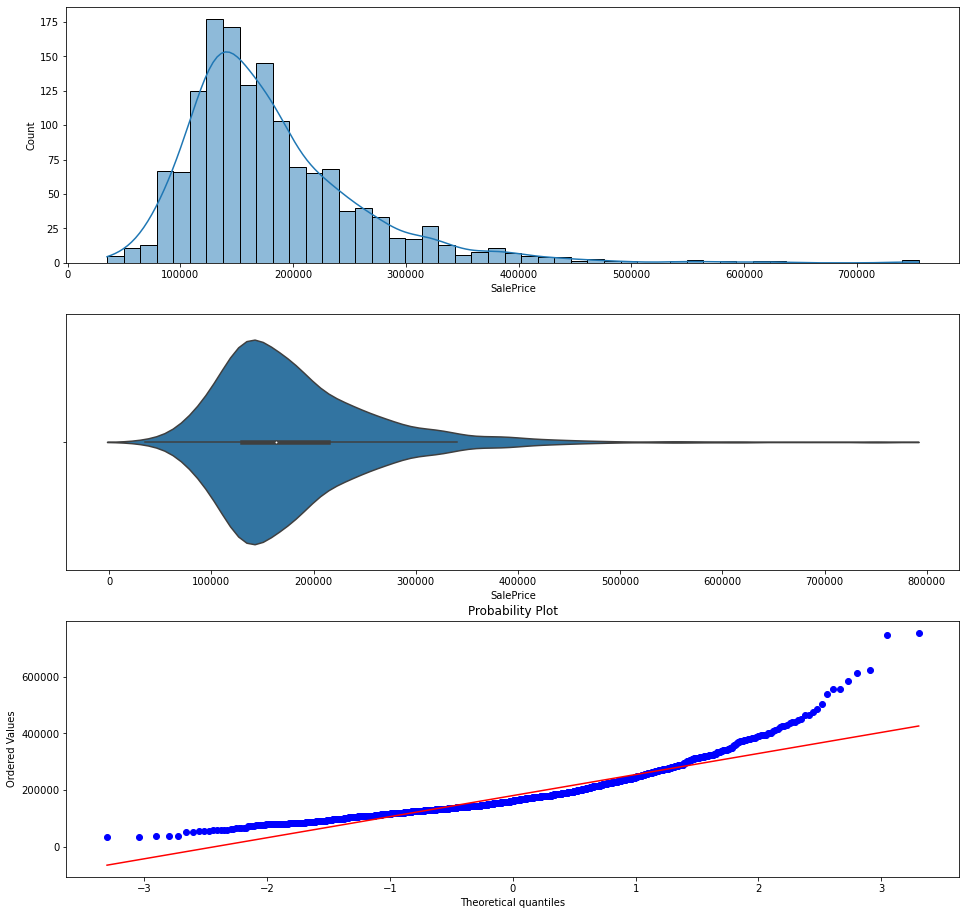

In [6]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(16, 16))
sns.histplot(x=train['SalePrice'], ax=ax[0],kde=True)
sns.violinplot(x= train['SalePrice'], ax=ax[1])
stats.probplot(train['SalePrice'], dist="norm",plot=ax[2])
plt.show()

*<font color = 'red'>
Takeaway:  
Visual inspection indicates right skew distribution on Sale Price
<font>*

Since many model works well with gaussian distribution , we can log transform the SalePrice

In [7]:
train['SalePrice'] = np.log1p(train['SalePrice'])

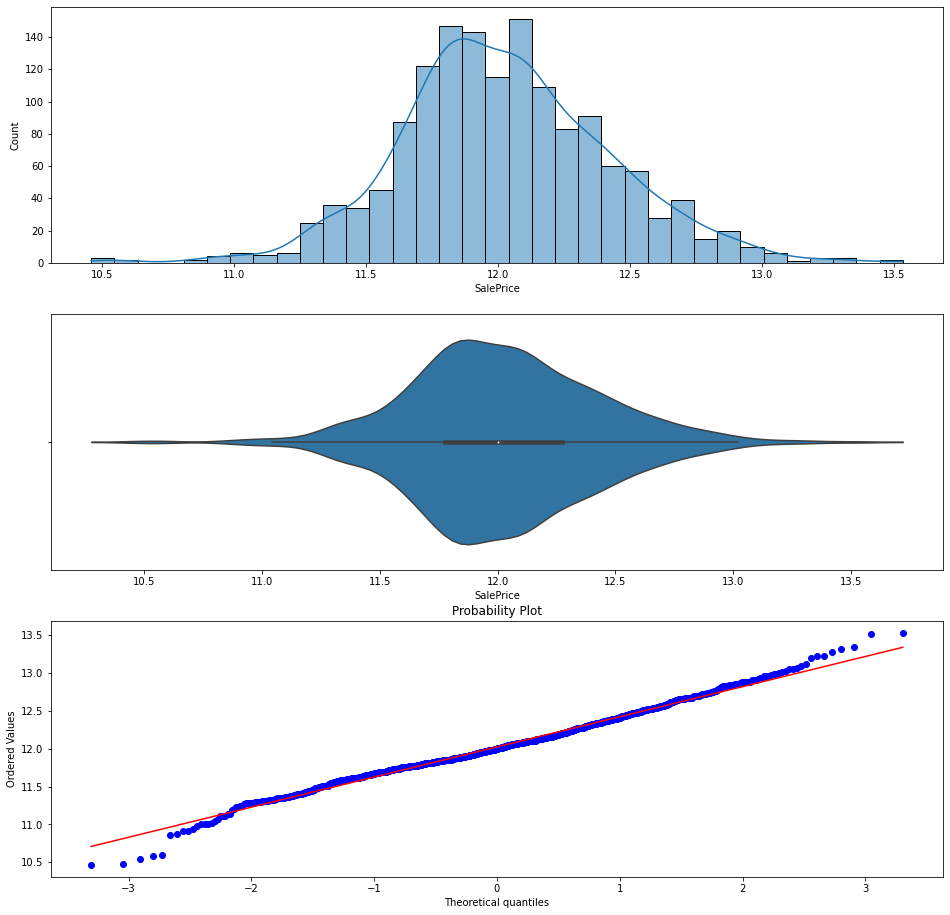

In [8]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(16, 16))
sns.histplot(x=train['SalePrice'], ax=ax[0],kde=True)
sns.violinplot(x= train['SalePrice'], ax=ax[1])
stats.probplot(train['SalePrice'], dist="norm",plot=ax[2])
plt.show()

*<font color = 'green'>
Takeaway:  
Visual inspection indicates approximate normal distribution of Sale Price
<font>*

### Changing to appropriate datatypes

In [9]:
# Lets combine both training and testing datasets together
test['SalePrice'] =np.nan
combined = pd.concat([train,test])

In [10]:
# MSSubClass,MoSold to string
combined[['MSSubClass','MoSold']] = combined[['MSSubClass','MoSold']].astype(str)

# GarageYrBlt, GarageArea to int
combined[['GarageYrBlt','GarageArea','GarageCars']] = (combined[['GarageYrBlt','GarageArea','GarageCars']]
                                                       .apply(pd.to_numeric))

## Data imputation

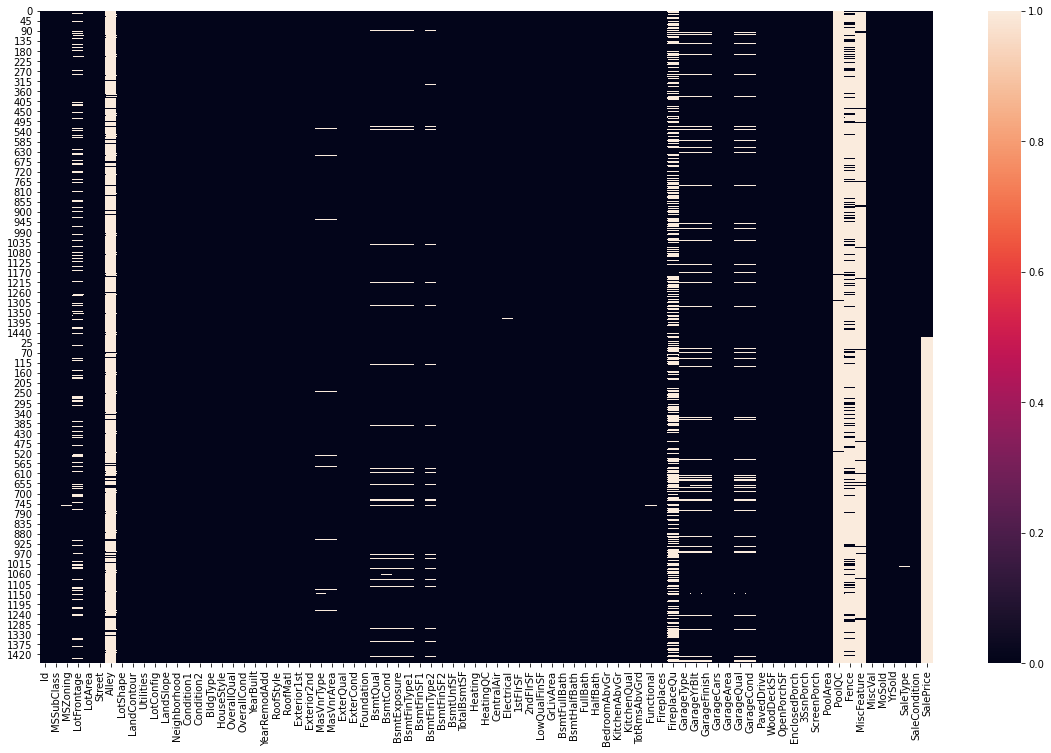

In [11]:
# Visually inspecting the missing values in the dataframe
plt.figure(figsize=(20,12))
sns.heatmap(combined.isnull())
plt.show()

*<font color = 'red'>
Takeaway:  
Visual inspection indicates lot of values missing in 'Alley', 'FirePlaceQu', 'PoolQC', 'Fence', 'MiscFeature'
<font>*

In [12]:
# Counting the missing value in the combined dataframe
train_nrows = train.shape[0]
missing_count = combined.isnull().sum().sort_values(ascending=False)
missing_percent = combined.isnull().sum()/train_nrows
missing_data = pd.concat([missing_count,missing_percent],axis=1).rename(columns={0:'missing_count',1:'missing_percent'})
missing_data[missing_data['missing_count']>0]

,missing_count,missing_percent
PoolQC,2909,1.992466
MiscFeature,2814,1.927397
Alley,2721,1.863699
Fence,2348,1.608219
SalePrice,1459,0.999315
FireplaceQu,1420,0.972603
LotFrontage,486,0.332877
GarageFinish,159,0.108904
GarageQual,159,0.108904
GarageCond,159,0.108904


#### Pool Variables

In [13]:
reg = re.compile(".*pool.*",re.IGNORECASE)
pool_columns = list(filter(reg.match,list(combined.columns)))
print("Pool related variables are : ",pool_columns)
combined.groupby('PoolQC',dropna=False).agg({'PoolArea':['sum',np.median,'count']})

Pool related variables are :  ['PoolArea', 'PoolQC']


PoolArea             
            sum median count
PoolQC                      
Ex         1439  370.0     4
Fa         1167  583.5     2
Gd         2594  657.0     4
NaN        1373    0.0  2909

In [14]:
combined.loc[(combined['PoolQC'].isnull()) & (combined['PoolArea'] > 0),['Id','PoolArea','PoolQC']]

,Id,PoolArea,PoolQC
960,2421,368,NaN
1043,2504,444,NaN
1139,2600,561,NaN


*<font color = 'blue'>
Takeaway:  
Looking at 'PoolQC' and 'PoolArea' at the same time, Except for three rows missing values in 'PoolQC' corresponds to zero 'PoolArea', implying those houses does not have any pool.
<font>*

In [15]:
# For the three records with 'PoolArea' > 0, impute the missing 'PoolQC' to 'Gd'
combined.loc[(combined['PoolQC'].isnull()) & (combined['PoolArea'] > 0),['PoolQC']] = 'Gd'

In [16]:
# For remaining missing value in 'PoolQC', fill the missing value with 'NA'
combined['PoolQC'] = combined['PoolQC'].fillna("NA")

In [17]:
combined.groupby('PoolQC',dropna=False).agg({'SalePrice':'mean'}).reset_index()

,PoolQC,SalePrice
0,Ex,12.944243
1,Fa,12.267739
2,Gd,12.185594
3,NA,12.022122


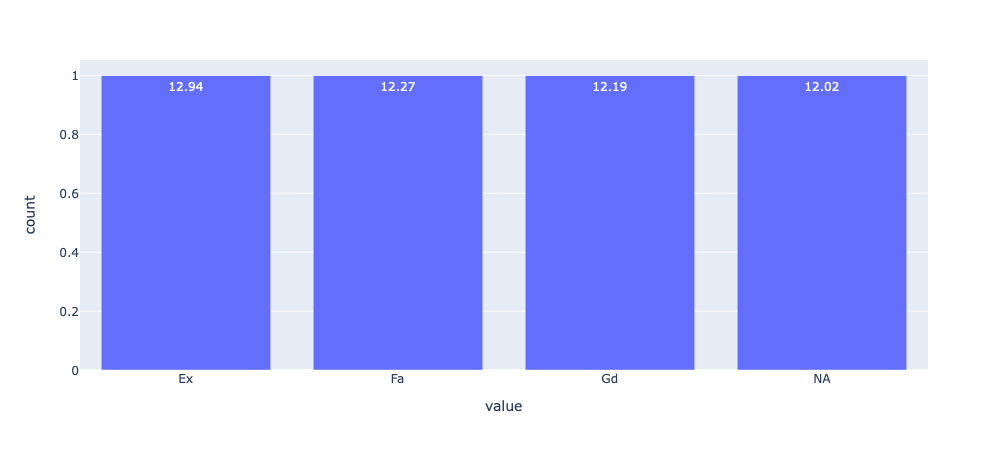

In [18]:
fig = px.bar(combined.groupby('PoolQC',dropna=False).agg({'SalePrice':'mean'}).reset_index().round(2),text='SalePrice')
fig.update_layout(showlegend=False).show()

*<font color = 'blue'>
Takeaway:  
House sale price is Ex > Fa > Gd > NA
</font>*

#### MiscFeature Valriables

Definition:  
MiscFeature: Miscellaneous feature not covered in other categories

MiscVal: $Value of miscellaneous feature

In [19]:
reg = re.compile(".*Misc.*",re.IGNORECASE)
Misc_columns = list(filter(reg.match,list(combined.columns)))
print("Miscellaneous variables are  : ",Misc_columns)
combined[Misc_columns].groupby('MiscFeature',dropna=False).agg({'MiscVal':['sum','count']})

Miscellaneous variables are  :  ['MiscFeature', 'MiscVal']


MiscVal      
                sum count
MiscFeature              
Gar2          43800     5
Othr          13000     4
Shed          72561    95
TenC           2000     1
NaN           17000  2814

In [20]:
combined[combined['MiscFeature'].isnull()]['MiscVal'].value_counts()

0        2813
17000       1
Name: MiscVal, dtype: int64

*<font color = 'blue'>
Takeaway:  
Except one record, missing value in 'MiscFeature' corresponds to $0 'MiscVal', implying these houses does not have any miscellaneous features
</font>*

In [21]:
# Impute  MiscFeature for this record (which has MiscValue) to 'Othr'
combined.loc[(combined['MiscFeature'].isnull()) & (combined['MiscVal']>0),'MiscFeature'] = 'Othr'

# Impute other records to 'NA', this means there is no misc features in this house
combined['MiscFeature'] = combined['MiscFeature'].fillna("NA")

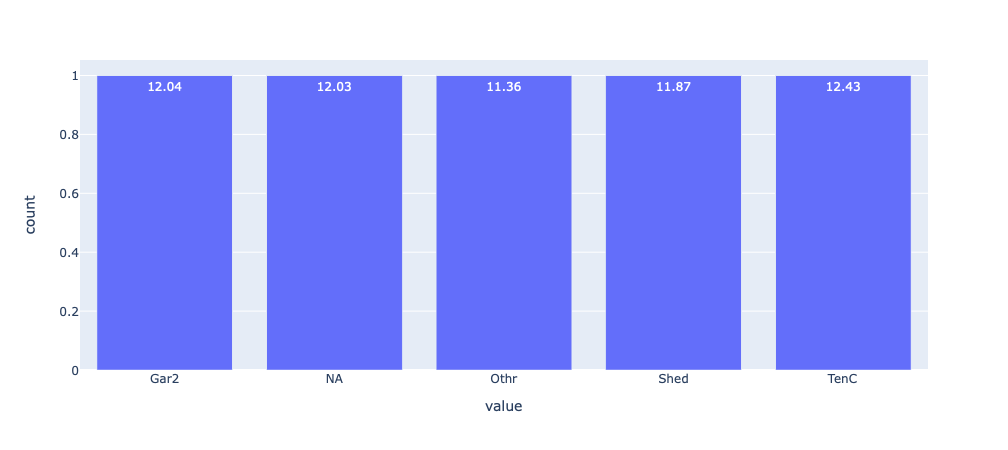

In [22]:
fig = px.bar(combined.groupby('MiscFeature',dropna=False).agg({'SalePrice':'mean'}).reset_index().round(2),text='SalePrice')
fig.update_layout(showlegend=False).show()

*<font color = 'blue'>
Takeaway:  
House with TenC 'MiscFeature' have higher mean 'SalePrice', followed by Gar2,No MiscFeatures, Shed and Othr
</font>*

## Alley Variables

In [23]:
reg = re.compile(".*Alley.*",re.IGNORECASE)
alley_columns = list(filter(reg.match,list(combined.columns)))
print("Alley variables are  : ",alley_columns)

Alley variables are  :  ['Alley']


In [24]:
combined['Alley'].value_counts(dropna=False)

NaN     2721
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [25]:
# Lets assume Missing data means no alley access to the house
combined['Alley'] = combined['Alley'].fillna("NA")

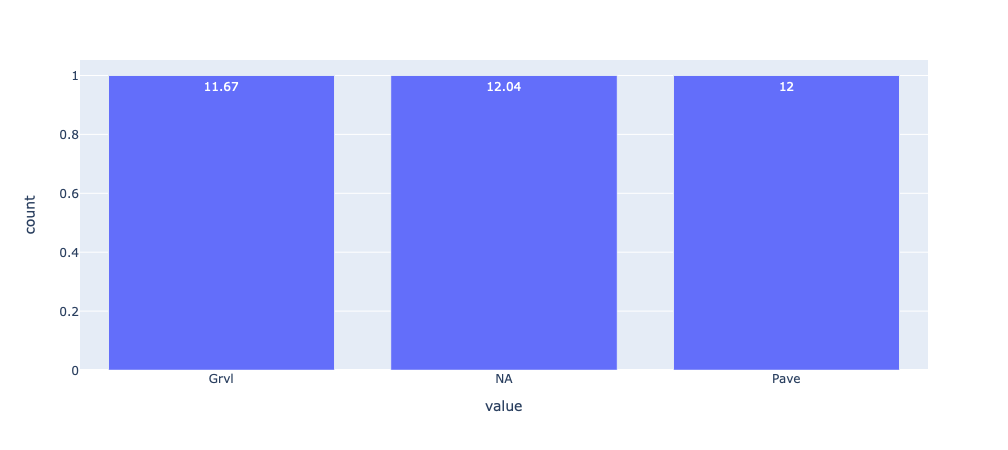

In [26]:
fig = px.bar(combined.groupby('Alley',dropna=False).agg({'SalePrice':'mean'}).reset_index().round(2),text='SalePrice')
fig.update_layout(showlegend=False).show()

*<font color = 'blue'>
Takeaway:  
Mean house price are  
    NA (No Alley Access) > Pave > Grvl
</font>*

## Fence Variables

In [27]:
reg = re.compile(".*Fence.*",re.IGNORECASE)
alley_columns = list(filter(reg.match,list(combined.columns)))
print("Fence variables are  : ",alley_columns)

Fence variables are  :  ['Fence']


In [28]:
combined['Fence'].value_counts(dropna=False)

NaN      2348
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64

In [29]:
# Lets assume Missing data means no Fence to the house
combined['Fence'] = combined['Fence'].fillna("NA")

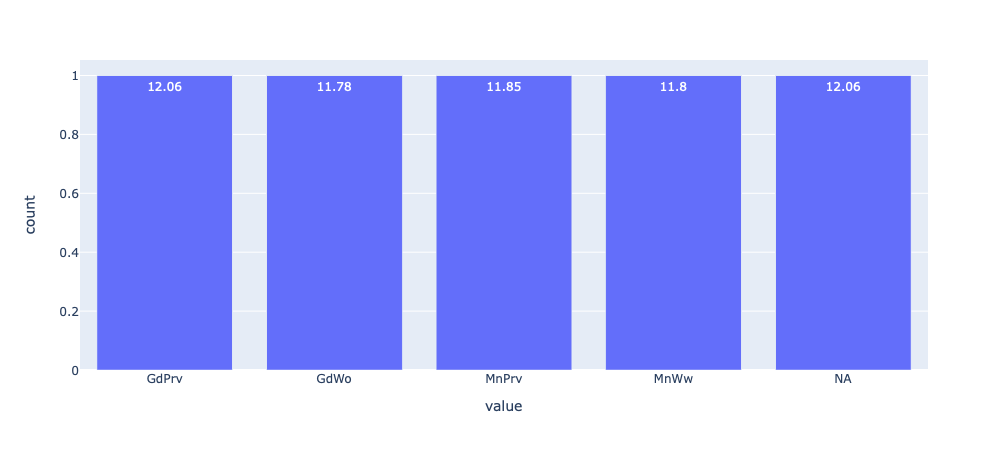

In [30]:
fig = px.bar(combined.groupby('Fence',dropna=False).agg({'SalePrice':'mean'}).reset_index().round(2),text = 'SalePrice')
fig.update_layout(showlegend=False).show()

## Fire Place Variables

In [31]:
reg = re.compile(".*Fire.*",re.IGNORECASE)
fire_columns = list(filter(reg.match,list(combined.columns)))
print("Fire Place variables are  : ",alley_columns)

Fire Place variables are  :  ['Fence']


In [32]:
combined.groupby(['Fireplaces','FireplaceQu'],dropna=False).size().reset_index()

,Fireplaces,FireplaceQu,0
0,0,NaN,1420
1,1,Ex,37
2,1,Fa,63
3,1,Gd,627
4,1,Po,46
5,1,TA,495
6,2,Ex,5
7,2,Fa,10
8,2,Gd,112
9,2,TA,92


*<font color = 'blue'>
Takeaway:  
Missing 'FireplaceQC' corresponds to zero 'FirePlaces', implying those house does not have fireplace
</font>*

In [33]:
# Here Missing FireplaceQu meaning Fireplace is not available.

combined['FireplaceQu'] = combined['FireplaceQu'].fillna("Na")

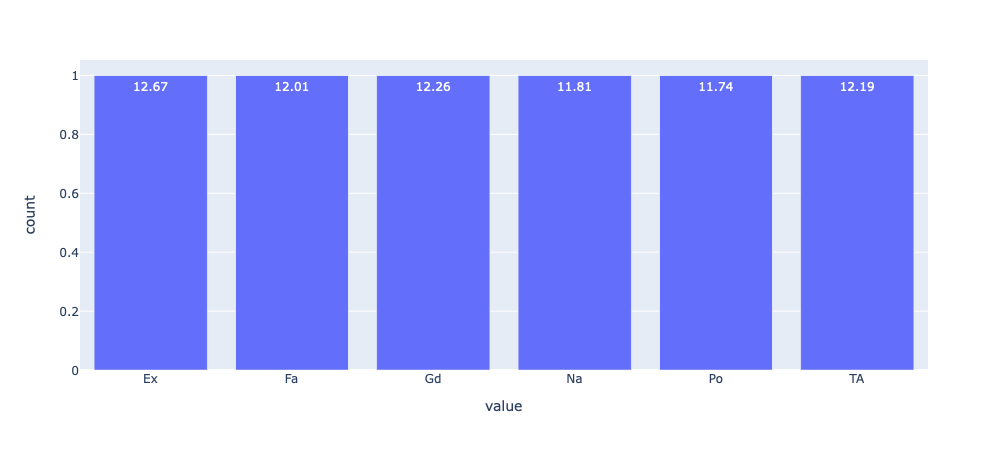

In [34]:
fig = px.bar(combined.groupby('FireplaceQu',dropna=False).agg({'SalePrice':'mean'}).reset_index().round(2),text = 'SalePrice')
fig.update_layout(showlegend=False).show()

## Lot variable

In [35]:
reg = re.compile(".*Lot.*",re.IGNORECASE)
lot_columns = list(filter(reg.match,list(combined.columns)))
print("Lot variables are  : ",lot_columns)

Lot variables are  :  ['LotFrontage', 'LotArea', 'LotShape', 'LotConfig']


In [36]:
# Assume missing value in LotFrontage meant, house does not have front lot
combined['LotFrontage'] = combined['LotFrontage'].fillna(0.0)

## Garage Variable

In [37]:
reg = re.compile(".*garage.*",re.IGNORECASE)
garage_columns = list(filter(reg.match,list(combined.columns)))
print("Garage variables are  : ",garage_columns)

Garage variables are  :  ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']


In [38]:
garage_cat_cols = ['GarageType','GarageFinish','GarageQual','GarageCond']
combined.groupby(garage_cat_cols,dropna=False).agg({'GarageCars':['sum','count']})

GarageCars      
                                                     sum count
GarageType GarageFinish GarageQual GarageCond                 
2Types     Fin          TA         TA                8.0     3
           RFn          TA         TA               15.0     5
           Unf          Fa         Fa                3.0     1
                                   TA                2.0     1
                        TA         TA               35.0    13
Attchd     Fin          Fa         TA                1.0     1
                        Gd         Gd                4.0     2
                                   TA                3.0     1
                        TA         Gd                6.0     2
                                   TA             1210.0   548
           RFn          Gd         Gd                6.0     3
                                   TA               16.0     8
                        TA         Gd                6.0     4
                                   TA             1408.0   701
           Unf          Fa         Fa                1.0     1
                                   Po                2.0     1
                                   TA               15.0    13
                        Gd         Gd                2.0     1
                                   TA                4.0     2
                        TA         Fa                6.0     4
                                   Po                1.0     1
                                   TA              684.0   430
Basment    Fin          Gd         TA                1.0     1
                        TA         TA               20.0    10
           RFn          TA         TA               11.0     8
           Unf          Fa         TA                4.0     4
                        TA         TA               20.0    13
BuiltIn    Fin          Gd         TA                2.0     1
                        TA         TA              309.0   126
           RFn          Fa         TA                3.0     2
                        TA         TA              102.0    46
           Unf          Fa         TA                1.0     1
                        TA         TA               16.0    10
CarPort    Unf          Fa         Fa                2.0     1
                                   TA                2.0     1
                        TA         TA               20.0    13
Detchd     Fin          Ex         Ex                1.0     1
                        Fa         TA                2.0     1
                        Gd         Ex                2.0     1
                        TA         Fa                2.0     1
                                   TA               36.0    20
           RFn          TA         TA               63.0    34
           Unf          Ex         Ex                1.0     1
                                   TA                3.0     1
                        Fa         Fa               48.0    36
                                   Po               10.0     7
                                   TA               72.0    53
                        Gd         TA                7.0     4
                        Po         Fa                1.0     1
                                   Po                4.0     4
                        TA         Fa               40.0    29
                                   Gd                6.0     3
                                   Po                1.0     1
                                   TA              904.0   579
           NaN          NaN        NaN               1.0     1
NaN        NaN          NaN        NaN               0.0   157

*<font color = 'blue'>
Takeaway:  
Except one , all the missing value in categorical garage features corresponds to 0 cars, implying those houses does not have garage
</font>*

In [39]:
# Impute the one missing values with 1 'GarageCars' with common values

# Finding out common values
combined[garage_cat_cols].mode()

,GarageType,GarageFinish,GarageQual,GarageCond
0,Attchd,Unf,TA,TA


In [40]:
# Imputing with common values
combined.loc[(combined['GarageQual'].isnull()) & (combined['GarageCars'] > 0),'GarageFinish']= 'Unf'
combined.loc[(combined['GarageQual'].isnull()) & (combined['GarageCars'] > 0),'GarageQual']= 'TA'
combined.loc[(combined['GarageQual'].isnull()) & (combined['GarageCars'] > 0),'GarageCond']= 'TA'

In [41]:
# Imputing the remaining missing (corresponding to zero 'GarageCars') columns with NA
combined[garage_cat_cols] = combined[garage_cat_cols].fillna('NA')

In [42]:
# Garagecars
combined.loc[combined['GarageCars'].isnull(),garage_columns]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
1116,Detchd,NaN,NA,NaN,NaN,NA,NA


*<font color = 'blue'>
Takeaway:  
Based on other garage features, missing 'GarageCars' implys zero cars
</font>*

In [43]:
# Imputing 'GarageCars'
combined.loc[combined['GarageCars'].isnull(),'GarageCars'] = 0.0

In [44]:
combined.groupby('GarageYrBlt',dropna=False).agg({'GarageCars':['sum','count']}).reset_index().tail(5)

GarageYrBlt GarageCars      
                       sum count
99       2008.0      159.0    61
100      2009.0       72.0    29
101      2010.0       13.0     5
102      2207.0        2.0     1
103         NaN        1.0   159

*<font color = 'blue'>
Takeaway:  
Looking at last row, there is one instance where we have 'GarageCars' as 1 , but no 'GarageYrBlt'
</font>*

In [45]:
combined.loc[(combined['GarageYrBlt'].isnull()) & (combined['GarageCars'] > 0),garage_columns+['YearBuilt']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,YearBuilt
666,Detchd,NaN,Unf,1.0,360.0,TA,NA,1910


In [46]:
# Impute 'GarageYrBlt' for the above instance with 1910, the year house was built. This is a resonable assumption.
combined.loc[(combined['GarageYrBlt'].isnull()) & (combined['GarageCars'] > 0),'GarageYrBlt']=1910

In [47]:
combined.groupby('GarageYrBlt',dropna=False).agg({'GarageCars':['sum','count']}).reset_index().tail(5)

GarageYrBlt GarageCars      
                       sum count
99       2008.0      159.0    61
100      2009.0       72.0    29
101      2010.0       13.0     5
102      2207.0        2.0     1
103         NaN        0.0   158

*<font color = 'blue'>
Takeaway:  
There is one instance which has 'GarageYrBlt' of 2207, which is in future so this needs to corrected.
</font>*

In [48]:
combined.loc[combined['GarageYrBlt']==2207,garage_columns+['YearBuilt']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,YearBuilt
1132,Attchd,2207.0,RFn,2.0,502.0,TA,TA,2006


In [49]:
# Update the 'GargeYrBlt' to 2006 , when the house was built
combined.loc[combined['GarageYrBlt']==2207, 'GarageYrBlt'] = 2006

In [50]:
combined.groupby('GarageYrBlt',dropna=False).agg({'GarageCars':['sum','count']}).reset_index().tail(5)

GarageYrBlt GarageCars      
                       sum count
98       2007.0      286.0   115
99       2008.0      159.0    61
100      2009.0       72.0    29
101      2010.0       13.0     5
102         NaN        0.0   158

*<font color = 'blue'>
Takeaway:  
All the missing value in 'GarageYrBlt' corresponds to zero 'GarageCars' implying these houses does not have garage
</font>*

In [51]:
combined.groupby('GarageArea',dropna=False).agg({'GarageCars':['sum','count']}).reset_index().tail(5)

GarageArea GarageCars      
                      sum count
599     1356.0        4.0     1
600     1390.0        3.0     1
601     1418.0        2.0     1
602     1488.0        4.0     1
603        NaN        0.0     1

*<font color = 'blue'>
Takeaway:  
One instance where 'GarageArea' is missing ,which corresponds to zero 'GarageCars' , implying thsi house does not have garage
</font>*

In [52]:
# Impute the missing values with median value
garage_num_cols = ['GarageYrBlt','GarageArea']
combined[garage_num_cols] = combined[garage_num_cols].fillna(combined[garage_num_cols].median())

## BsmtFinType2

BsmtQual: Height of the basement  
BsmtCond: General condition of the basement  
BsmtExposure: Walkout or garden level basement walls  
BsmtFinType1: Quality of basement finished area  
BsmtFinSF1: Type 1 finished square feet  
BsmtFinType2: Quality of second finished area (if present)  
BsmtFinSF2: Type 2 finished square feet  
BsmtUnfSF: Unfinished square feet of basement area  
TotalBsmtSF: Total square feet of basement area  

In [53]:
reg = re.compile(".*Bsmt.*",re.IGNORECASE)
bsmt_columns = list(filter(reg.match,list(combined.columns)))
print("Basement Columns are : ", bsmt_columns)

Basement Columns are :  ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']


In [54]:
combined[bsmt_columns].isnull().sum()

BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinSF1       1
BsmtFinType2    80
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
dtype: int64

In [55]:
# BsmtFullBath & BsmtHalfBath
combined.loc[(combined['BsmtFullBath'].isnull()) | (combined['BsmtHalfBath'].isnull()),bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN


*<font color = 'blue'>
Takeaway:  
Other basement features indicate above two instances does not have basement bathroomm
</font>*

In [56]:
# Imputing BsmtHalfBath & BsmtFullBath
combined.loc[(combined['BsmtFullBath'].isnull()) | (combined['BsmtHalfBath'].isnull()),'BsmtFullBath'] = 0.0
combined.loc[(combined['BsmtFullBath'].isnull()) | (combined['BsmtHalfBath'].isnull()),'BsmtHalfBath'] = 0.0

In [57]:
# BsmtFinSF1 , BsmtFinSF2, BsmtUnfSF, TotalBsmtSF
(combined.loc[(combined['BsmtFinSF1'].isnull()) | 
              (combined['BsmtFinSF2'].isnull()) |
              (combined['BsmtUnfSF'].isnull()) |
              (combined['TotalBsmtSF'].isnull()) 
              ,bsmt_columns]
)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


*<font color = 'blue'>
Takeaway:  
Other basement features indicate above  instance does not have basement
</font>*

In [58]:
combined.loc[combined['BsmtFinSF1'].isnull(),'BsmtFinSF1'] = 0
combined.loc[combined['BsmtFinSF2'].isnull(),'BsmtFinSF2'] = 0
combined.loc[combined['BsmtUnfSF'].isnull(),'BsmtUnfSF'] = 0
combined.loc[combined['TotalBsmtSF'].isnull(),'TotalBsmtSF'] = 0

In [59]:
# BsmtQual,BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
combined.loc[(combined['BsmtQual'].isnull()) & (combined['TotalBsmtSF']>0),bsmt_columns ]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0


In [60]:
combined[['BsmtCond','BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2']].mode()

,BsmtCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2
0,TA,TA,No,Unf,Unf


In [61]:
# For the observation with TotalBsmtSF (i.e houses that have basement) , impute missing basement features with common value
combined.loc[(combined['BsmtQual'].isnull()) & (combined['TotalBsmtSF']>0),'BsmtQual' ] = 'TA'
combined.loc[(combined['BsmtCond'].isnull()) & (combined['TotalBsmtSF']>0),'BsmtCond' ] = 'TA'
combined.loc[(combined['BsmtExposure'].isnull()) & (combined['TotalBsmtSF']>0),'BsmtExposure' ] = 'No'
combined.loc[(combined['BsmtFinType1'].isnull()) & (combined['TotalBsmtSF']>0),'BsmtFinType1' ] = 'Unf'
combined.loc[(combined['BsmtFinType2'].isnull()) & (combined['TotalBsmtSF']>0),'BsmtFinType2' ] = 'Unf'

In [62]:
(combined.loc[(combined['BsmtQual'].isnull()) | 
              (combined['BsmtCond'].isnull()) |
              (combined['BsmtExposure'].isnull()) |
              (combined['BsmtFinType1'].isnull())|
              (combined['BsmtFinType2'].isnull()) 
              ,'TotalBsmtSF'].describe()
)

count    79.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: TotalBsmtSF, dtype: float64

*<font color = 'blue'>
Takeaway:  
Missing values in basement features indicate absense of basemnet in those houses
</font>*

In [63]:
col = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
combined[col] = combined[col].fillna('NA')

## Masonry veneer

MasVnrType: Masonry veneer type  
MasVnrArea: Masonry veneer area in square feetm

In [64]:
reg = re.compile(".*MasVnr.*",re.IGNORECASE)
masvnr_columns = list(filter(reg.match,list(combined.columns)))
print("Masonry veneer variables are  : ",masvnr_columns)

Masonry veneer variables are  :  ['MasVnrType', 'MasVnrArea']


In [65]:
(combined.loc[combined['MasVnrArea']>0,masvnr_columns]
 .groupby('MasVnrType',dropna=False)
 .agg({'MasVnrArea':['sum','mean',np.median,'count']})
)

MasVnrArea                         
                  sum        mean median count
MasVnrType                                    
BrkCmn         4887.0  195.480000  161.0    25
BrkFace      230010.0  262.269099  203.0   877
None           1232.0  176.000000  285.0     7
Stone         59648.0  240.516129  200.0   248
NaN             198.0  198.000000  198.0     1

In [66]:
combined.loc[((combined['MasVnrType']=='None')),masvnr_columns].sort_values('MasVnrArea',ascending=False).head(8)

,MasVnrType,MasVnrArea
1300,None,344.0
1334,None,312.0
624,None,288.0
209,None,285.0
992,None,1.0
1230,None,1.0
773,None,1.0
1,None,0.0


*<font color = 'blue'>
Takeaway:  
Three instances where 'MasVnrArea' is 1, and 'MasVnrType' is None, Most likely these three houses does not have any Masonry veneer type
</font>*

In [67]:
# Update the above three values to zero
combined.loc[((combined['MasVnrType']=='None') & (combined['MasVnrArea']==1)) ,'MasVnrArea'] =0.0

In [68]:
# Impute with most common value for MasVnrType when 'MasVnrArea' is greater than zero
combined.loc[((combined['MasVnrType']=='None') & (combined['MasVnrArea']>0)) ,'MasVnrType'] = 'BrkFace'
combined.loc[((combined['MasVnrType'].isnull()) & (combined['MasVnrArea']>0)) ,'MasVnrType'] = 'BrkFace'

In [69]:
# Imputing the remining missing value assuming these houses does not have any Masonary Venner type
combined['MasVnrType'] = combined['MasVnrType'].fillna('None')
combined['MasVnrArea'] = combined['MasVnrArea'].fillna(0)

## Electrical

In [70]:
combined['Electrical'].value_counts(dropna=False)

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [71]:
# Impute with most common value
combined.loc[combined['Electrical'].isnull(),'Electrical'] = 'SBrKr'

### Encoding Cat Variable

In [73]:
combined = pd.get_dummies(combined)
train = combined[:train_nrows]
test = combined[train_nrows:].drop('SalePrice',axis = 1)

## Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [ ]:
train_X , valid_X, train_y, valid_y = train_test_split(train.drop('SalePrice',axis = 1),train['SalePrice'],
                                                       test_size = 0.3)

### Decision Tree Regressor 1

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(train_X,train_y)

In [ ]:
from sklearn import tree
dot_data = tree.export_graphviz(model,out_file=None,feature_names=train_X.columns)
graph = graphviz.Source(dot_data)
graph

In [ ]:
# training error
training_error = math.sqrt(mean_squared_log_error(model.predict(train_X),train_y))

# Validation error
validation_error = math.sqrt(mean_squared_log_error(model.predict(valid_X),valid_y))



In [ ]:
print("Training RMSE is ", training_error,"\nValidation RMSE is ",validation_error)

In [ ]:
df_submission = pd.DataFrame({'id':test['Id'],'saleprice':model.predict(test)})
df_submission.to_csv("submission_decision_tree_1.csv",index=False)

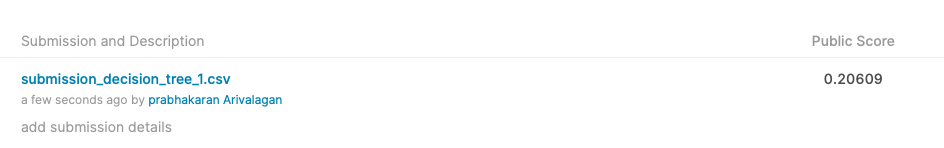

In [ ]:
model.get_params()

In [ ]:
param_grid = [
  {'max_depth': list(range(1,10)), 
   'max_features': ['auto', 'sqrt', 'log2'],
   'min_samples_split':list(range(2,10)),
   'min_samples_leaf':list(range(2,10))
  }
 ]

In [ ]:
model = DecisionTreeRegressor()
grid_model = GridSearchCV(model,param_grid=param_grid)
grid_model.fit(train_X,train_y)

In [ ]:
grid_model.best_params_

In [ ]:
model = grid_model.best_estimator_
# training error
training_error = math.sqrt(mean_squared_log_error(model.predict(train_X),train_y))

# Validation error
validation_error = math.sqrt(mean_squared_log_error(model.predict(valid_X),valid_y))

In [ ]:
print("Training RMSE is ", training_error,"\nValidation RMSE is ",validation_error)

In [ ]:
df_submission = pd.DataFrame({'id':test['Id'],'saleprice':model.predict(test)})
df_submission.to_csv("submission_decision_tree_2.csv",index=False)

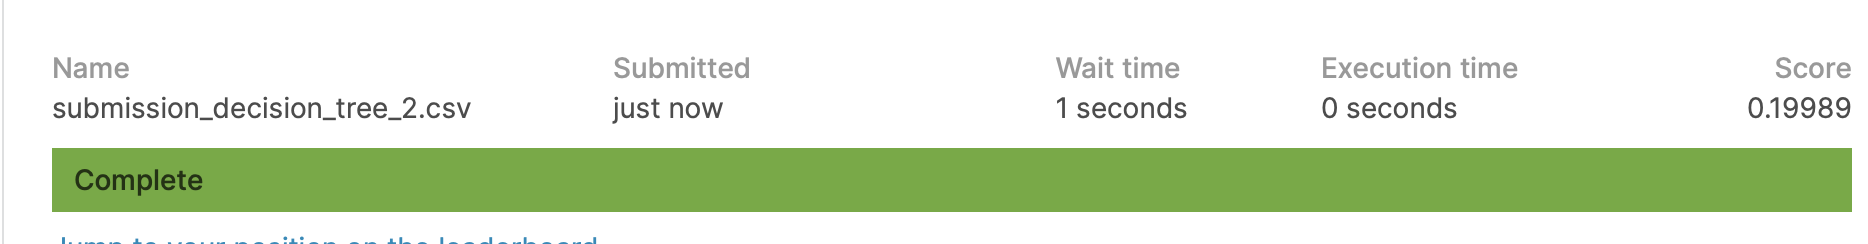